In [206]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import accuracy_score,log_loss,precision_score,f1_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from mlfinlab.features import fracdiff
import matplotlib.pyplot as plt
import feather
import uuid
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf


In [193]:
def check_for_stacionary(X):
    p=adfuller(X)[1]
    return p

def log_returns(price,lag=1):
    out=np.log(price)-np.log(price.shift(lag))
    return out

def plotMinFFD(df0):
    from statsmodels.tsa.stattools import adfuller
    from mlfinlab.features import fracdiff
    #if min(df0[['serie']]): print ('Numero nagativo->Log nao existe!!!!!')
    path,instName='./','ES1_Index_Method12'
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr']) 
    for d in np.linspace(0,1,11):
        df1=np.log(df0[['serie']]).resample('1D').last().dropna() # downcast to daily obs 
        df2=fracdiff.frac_diff_ffd(df1,d,thresh=0.01)
        df2=df2.dropna()
        corr=np.corrcoef(df1.loc[df2.index,'serie'],df2['serie'])[0,1]
        df2=adfuller(df2['serie'],maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    #out.to_csv(path+instName+'_testMinFFD.csv')
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    plt.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted') 
    #plt.savefig(path+instName+'_testMinFFD.png')
    return out

# Key points

In Advances in Financial Machine Learning, Chapter 5, Fractional difference is presented in order to archive stationarity with memory. 

"The dilemma is that returns are stationary, however memory-less, and prices have memory, however they are non-stationary. The question arises: What is the minimum amount of differentiation that makes a price series stationary while preserving as much memory as possible?"

1) Generate fractal difference from price returns

2) Calculate the correlation and cross correlation

In [118]:
def guid():
    return uuid.uuid4().hex

path='Features 20 tick/PETR31m/PETR31m'.format(guid())
data = feather.read_dataframe(path).set_index(['date_time'])
data=pd.DataFrame(data[['close']]).loc[datetime(2018,1,1):datetime(2020,1,1)]
data['ret']=log_returns(data)
data['retsum']=data['ret'].cumsum()
data=data.dropna()

In [226]:
#Calculating the 0.9 to 0.1 fractional difference
for i in tqdm(range(10,-1,-1),position=0, leave=True):
    d=i/10
    frac=fracdiff.frac_diff_ffd(data[['retsum']],d,thresh=0.001)
    data[f'frac{d}']=frac
    
dataf=data.copy().dropna()


100%|██████████| 11/11 [01:32<00:00,  8.39s/it]


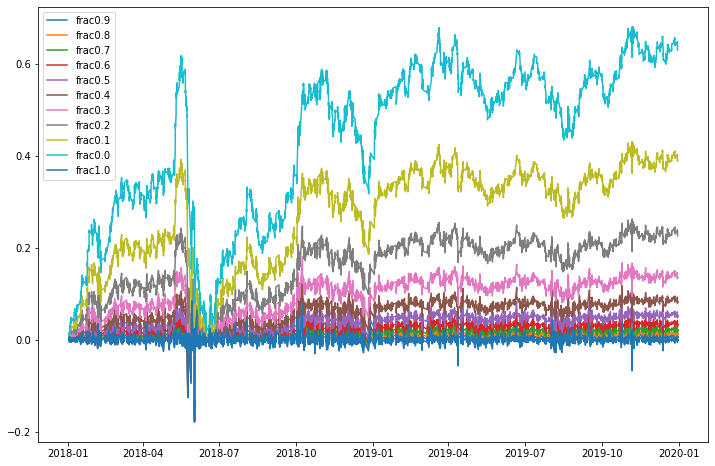

In [227]:
coli=3
fig,aux=plt.subplots(figsize=(12,8))
aux.plot(data[dataf.columns.values[coli:]])#,label=dataf.columns.values[1:].tolist())
plt.legend(dataf.columns.values[coli:].tolist())
plt.show()

In [228]:
len(dataf)/len(data)

0.992836533678241

Calculating the p-value, price and return correlation with fractional diffference

In [326]:
#p-value
pval=[]
#price correlation
pricecorr=[]
#return correlation
retcorr=[]
ind=[]
for i in tqdm(range(10,-1,-1),position=0,leave=True):
    d=i/10
    p_frac=check_for_stacionary(dataf[f'frac{d}'])
    pval.append(p_frac)
    pcorr=dataf['close'].corr(dataf[f'frac{d}'])
    pricecorr.append(pcorr)
    rcorr=dataf['ret'].corr(dataf[f'frac{d}'])
    retcorr.append(rcorr)
    ind.append(f'frac{d}')

100%|██████████| 11/11 [00:23<00:00,  2.13s/it]


In [328]:
s=pd.DataFrame(pval,columns=['pval'],index=ind)
s['pcorr']=pricecorr
s['rcorr']=retcorr
s=s.sort_values(by='pcorr', ascending=0)
s

,pval,pcorr,rcorr
frac0.0,1.637333e-01,0.997217,0.009759
frac0.1,1.576527e-01,0.996471,0.029312
frac0.2,1.215384e-01,0.991943,0.065069
frac0.3,7.911934e-02,0.981054,0.120924
frac0.4,4.202201e-02,0.959370,0.204343
frac0.5,1.741436e-02,0.918562,0.321992
frac0.6,5.655512e-03,0.846766,0.473124
frac0.7,8.406097e-04,0.726013,0.649357
frac0.8,5.588743e-05,0.572414,0.803941
frac0.9,6.021846e-09,0.357083,0.932112


/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


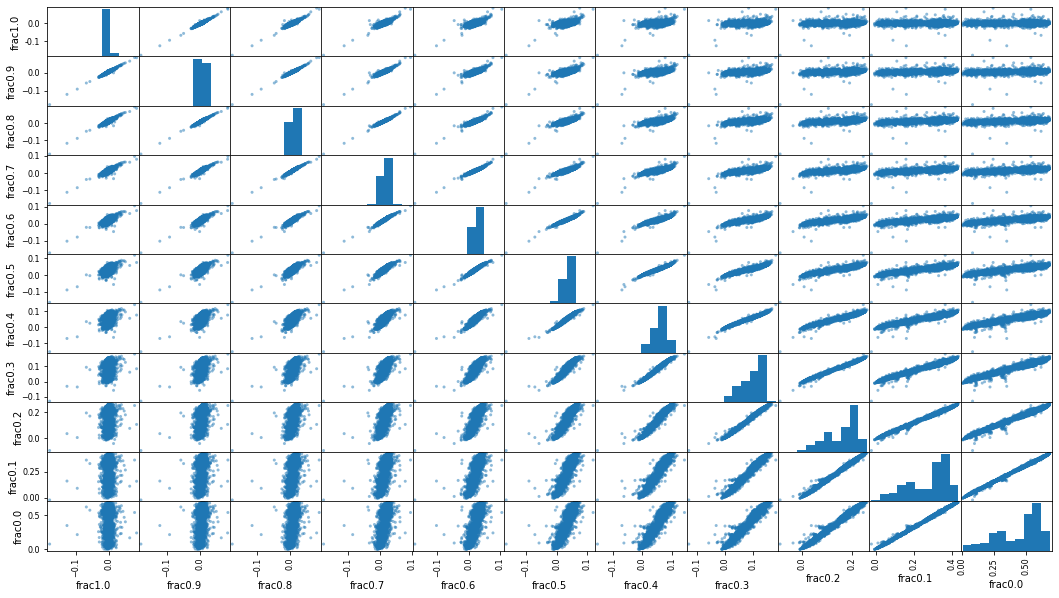

In [329]:
pd.scatter_matrix(dataf[ind],figsize=(18,10))
plt.show()

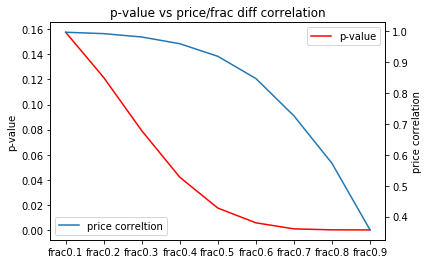

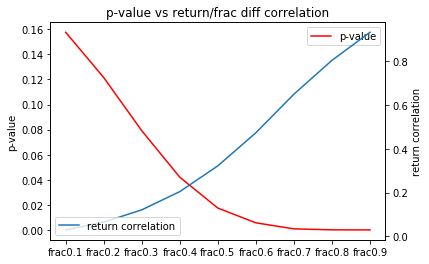

In [231]:
fig,aux=plt.subplots()
aux.plot(s['pval'],'r',label='p-value')
plt.ylabel('p-value')
plt.legend(loc=0)
aux=aux.twinx()
aux.plot(s['pcorr'],label='price correltion')
plt.ylabel('price correlation')
plt.legend(loc=3)
plt.title('p-value vs price/frac diff correlation')
plt.show()

fig,aux=plt.subplots()
aux.plot(s['pval'],'r',label='p-value')
plt.ylabel('p-value')
plt.legend(loc=0)
aux=aux.twinx()
aux.plot(s['rcorr'],label='return correlation')
plt.ylabel('return correlation')
plt.legend(loc=3)
plt.title('p-value vs return/frac diff correlation')
plt.show()

#Serial correletion

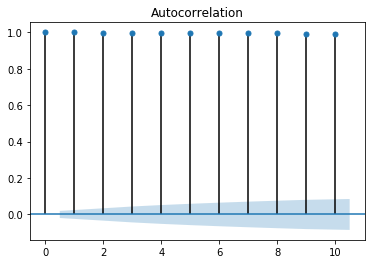

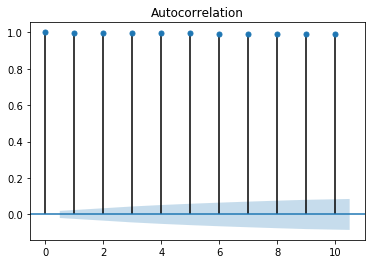

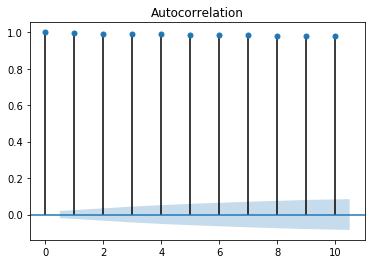

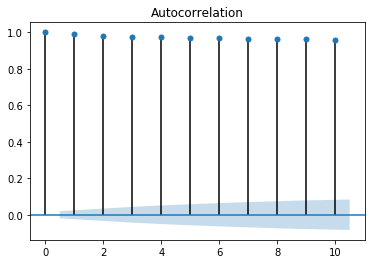

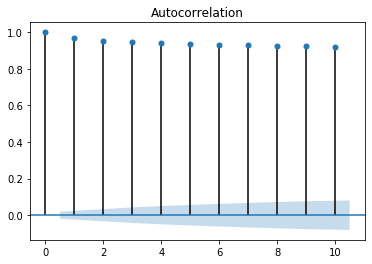

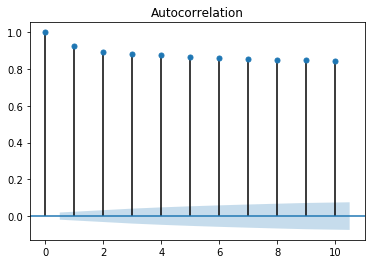

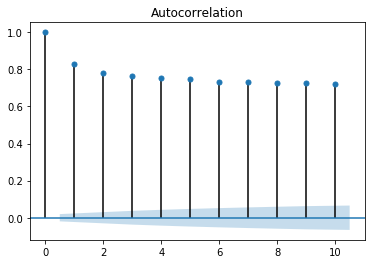

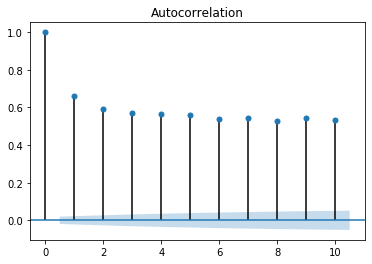

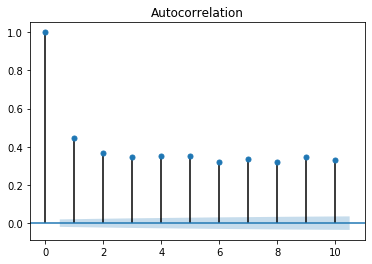

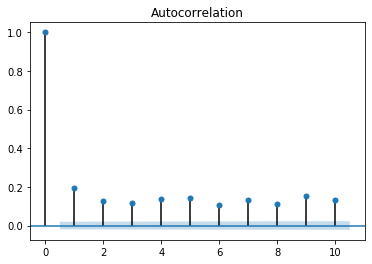

In [224]:
for i in range(0,10):
    d=i/10
    plot_acf(data[f'frac{d}'].dropna(),lags=10)
    plt.show()

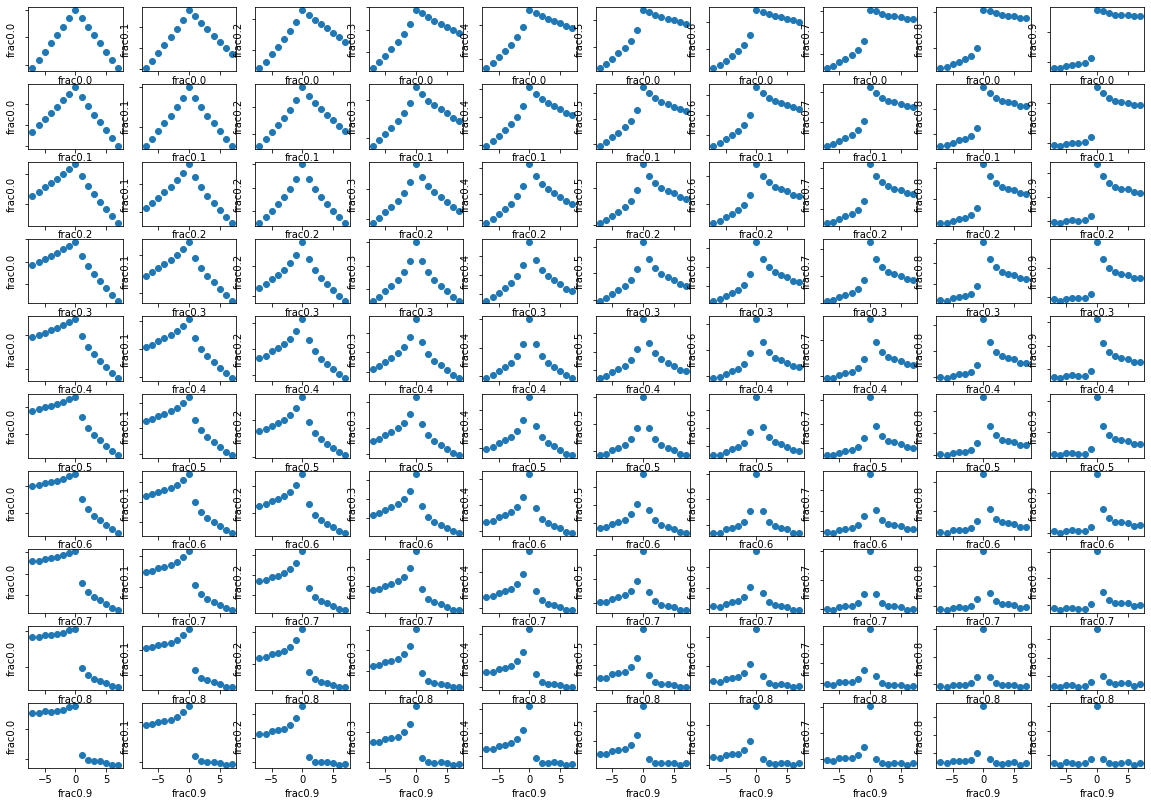

In [425]:
# Cross correlation bet two vectors measures the similarity bettween vector x and shifted vector y
sx=10
sy=10
fig,ax=plt.subplots(sx,sy,figsize=(20,14),sharex=True)#,sharey=True)
lg=[]
for i in range(sx):
    d1=i/10
    for j in range(sy):
        d2=j/10
        x=data[f'frac{d1}'].dropna()
        y=data[f'frac{d2}'].loc[x.index].dropna()
        x=x.loc[y.index]
        ax[i,j].xcorr(x,y, usevlines=False, normed=True, maxlags=7)
        ax[i,j].set(xlabel=f'frac{d1}', ylabel=f'frac{d2}')
        ax[i,j].set_yticklabels([])

        
plt.show()

# Feature Analysis